# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random
from bintrees import FastRBTree
from queue import PriorityQueue

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

___

# Rozwiązanie

In [3]:
%matplotlib notebook

## Generowanie losowych odcinków

In [4]:
def generate_lines(num_of_lines, x_range, y_range):
    lines = []
    x_pts_coords = set()
    lines_left = num_of_lines
    random_range = lambda x, y: (random.uniform(x[0], x[1]), random.uniform(y[0], y[1]))
    
    while lines_left > 0:
        fst_line_pt = random_range(x_range, y_range)
        snd_line_pt = random_range(x_range, y_range)
        
        if fst_line_pt == snd_line_pt or fst_line_pt[0] == snd_line_pt[0] \
            or fst_line_pt[0] in x_pts_coords or snd_line_pt in x_pts_coords:
                continue
        elif fst_line_pt[0] < snd_line_pt[0]:
            lines.append((fst_line_pt, snd_line_pt))
        else:
            lines.append((snd_line_pt, fst_line_pt))
            
        x_pts_coords.add(fst_line_pt[0])
        x_pts_coords.add(snd_line_pt[0])
        lines_left -= 1
        
    return lines

## Odczyt linii wprowadzonych przez użytkownika

In [5]:
def lines_from(plot):
    lines = []
    x_pts_coords = set()

    for data in plot.get_added_lines():
        for line in data.lines:
            fst_line_pt = (line[0][0], line[0][1])
            snd_line_pt = (line[1][0], line[1][1])
            
            if fst_line_pt == snd_line_pt or fst_line_pt[0] == snd_line_pt[0] \
                or fst_line_pt[0] in x_pts_coords or snd_line_pt in x_pts_coords:
                continue
            elif fst_line_pt[0] < snd_line_pt[0]:
                lines.append((fst_line_pt, snd_line_pt))
            else:
                lines.append((snd_line_pt, fst_line_pt))
                
            x_pts_coords.add(fst_line_pt[0])
            x_pts_coords.add(snd_line_pt[0])
        
    return lines

## Zbiory danych

### zbiór nr 0 : losowy zbiór linii

<IPython.core.display.Javascript object>


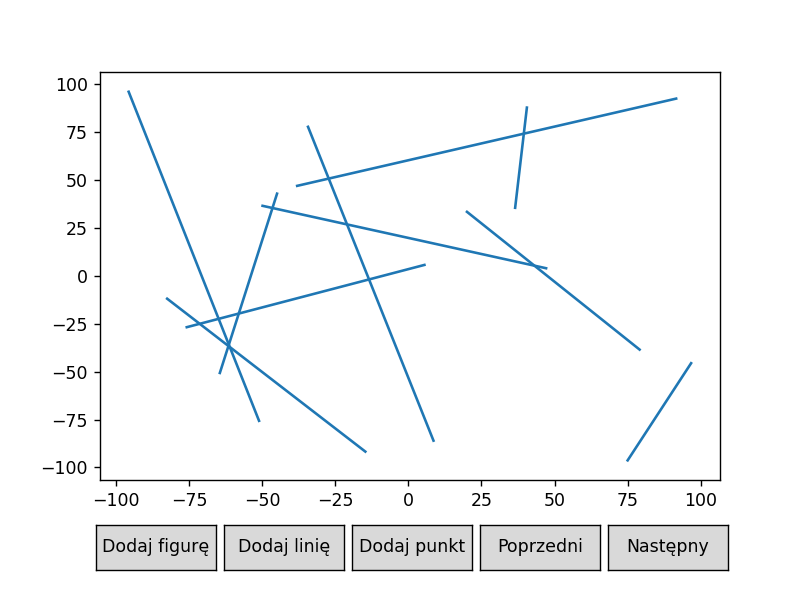

In [25]:
data_lines_0 = generate_lines(10, (-100, 100), (-100, 100))

plot = Plot([Scene(lines=[LinesCollection(data_lines_0)])])
plot.draw()

### zbiór nr 1

<IPython.core.display.Javascript object>


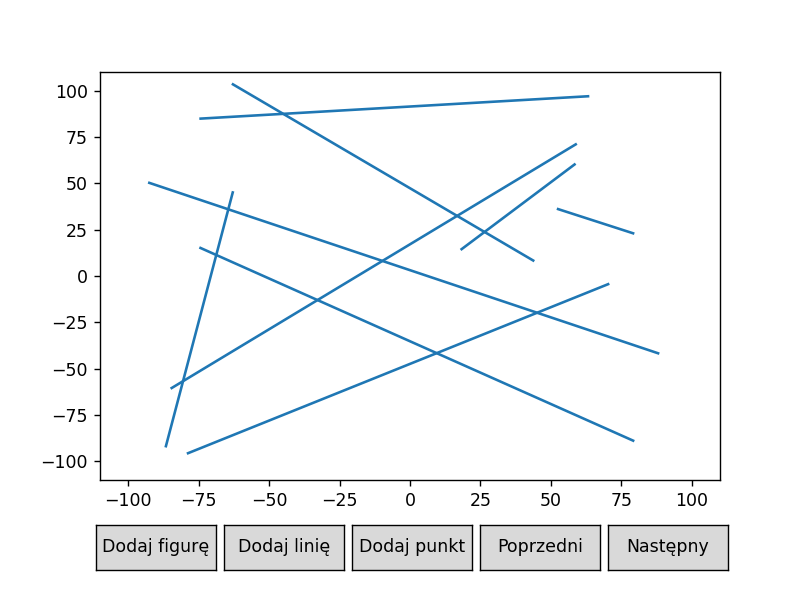

In [26]:
plot = Plot(scenes=[Scene(points=[PointsCollection([(-100, -100), (100, 100)], color="white")])])
plot.draw()

In [27]:
data_lines_1 = lines_from(plot)

### zbiór nr 2

<IPython.core.display.Javascript object>


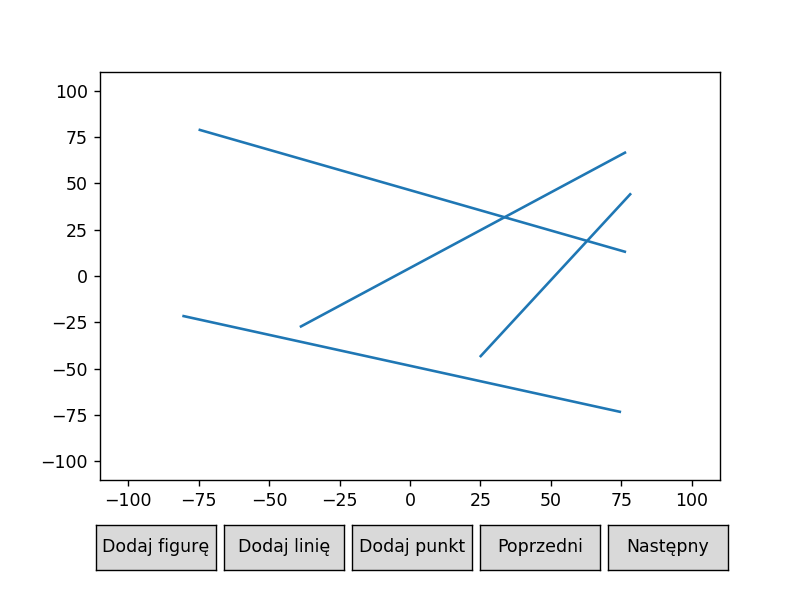

In [62]:
plot = Plot(scenes=[Scene(points=[PointsCollection([(-100, -100), (100, 100)], color="white")])])
plot.draw()

In [63]:
data_lines_2 = lines_from(plot)

### zbiór nr 3

<IPython.core.display.Javascript object>


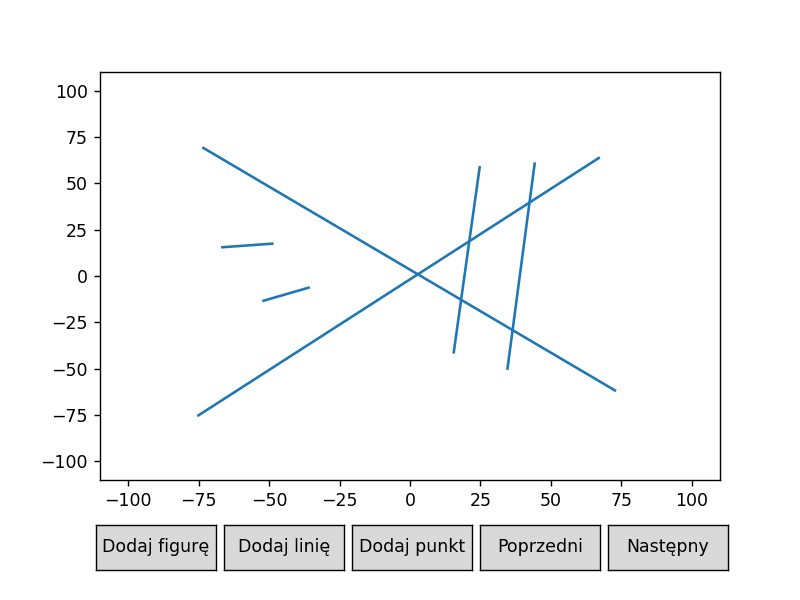

In [52]:
plot = Plot(scenes=[Scene(points=[PointsCollection([(-100, -100), (100, 100)], color="white")])])
plot.draw()

In [53]:
data_lines_3 = lines_from(plot)

## Funkcje pomocnicze

In [28]:
def det_3x3(pt_a, pt_b, pt_c):
    return (pt_a[0]*pt_b[1] + pt_b[0]*pt_c[1] + pt_c[0]*pt_a[1]
           - pt_c[0]*pt_b[1] - pt_a[0]*pt_c[1] - pt_b[0]*pt_a[1])

In [29]:
def angle_orientation(pt_a, pt_b, pt_c, tolerance=10**(-12)):
    det_val = det_3x3(pt_a, pt_b, pt_c)
    
    if det_val > tolerance:
        return -1
    elif det_val < -tolerance:
        return 1
    else:
        return 0

## Algorytm zamiatania 
## - sprawdzenie czy przynajmniej jedna para odcinków zbioru się przecina

#### Reprezentacja linii w postaci klasy (potrzebne do struktury drzewa)

In [30]:
class Line:
    # zdefiniowanie klasy Line, która opisuje atrybuty:
    # - self.line : linię jako krotkę punktów
    # - self.fst_pt : punkt początkowy linii
    # - self.snd_pt : punkt końcowy linii
    # - self.a : nachylenie prostej w układzie współrzędnych
    # - self.b : wyraz wolny prostej w układzie współrzędnych
    
    # metody:
    # - x_val_now : metoda statyczna, pozwalająca na zmianę wartości wsp. x
    #               dla wszystkich instancji klasy Line, potrzebnych m.in.
    #               do porządkowania (porównywania) linii w strukturze stanu
    # - get_line : zwraca reprezentację linii w postaci krotki punktów
    # - __gt__ : metoda magiczna, która pozwala na porównywanie linii
    # - __eq__ : metoda magiczna, która pozwala na wskazanie identyczności linii
    # - __hash__ : metoda haszująca, która pozwala na nadanie unikatowego identyfikatora dla linii
    
    
    def __init__(self, fst_pt, snd_pt):
        self.line = (fst_pt, snd_pt)
        self.fst_pt = fst_pt
        self.snd_pt = snd_pt
        self.a = (snd_pt[1] - fst_pt[1])/(snd_pt[0] - fst_pt[0])
        self.b = fst_pt[1] - fst_pt[0]*self.a
        
    @staticmethod
    def x_val_now(x):
        Line.x_val = x

    def get_line(self):
        return self.line
        
    def __gt__(self, other):
        return self.a*Line.x_val + self.b > other.a*Line.x_val + other.b
    
    def __eq__(self, other):
        return self.fst_pt == other.fst_pt and self.snd_pt == other.snd_pt
    
    def __hash__(self):
        return hash(self.line)

#### sprawdzenie przecinania się na podstawie wyznacznika

In [31]:
def lines_intersection(fst_line, snd_line):
    # sprawdzenie czy podane linie się przecinają
    
    if angle_orientation(fst_line[0], fst_line[1], snd_line[0]) != angle_orientation(fst_line[0], fst_line[1], snd_line[1]) \
       and angle_orientation(snd_line[0], snd_line[1], fst_line[0]) != angle_orientation(snd_line[0], snd_line[1], fst_line[1]):
        return True
    return False

#### Sprawdzenie czy choć jedna para odcinków się przecina

In [32]:
def check_intersection(data_lines):
    # funkcja odpowiedzialna za sprawdzenie czy istnieje przynajmniej jedno przecięcie linii
    
    # sortowanie linii wg współrzędnych osi x dla początkowych punktów
    # zdefiniowanie kierunku zamiatania - wzdłuż osi X od najmniejszych do największych wartości
    data_lines.sort(key=lambda line: line[0][0])
    
    # struktura stanu miotły jako drzewo czerwono-czarne
    # zrównoważone drzewo poszukiwań
    State = FastRBTree()
    # struktura zdarzeń jako kolejka priorytetowa
    Queue = PriorityQueue()
    
    # wyznaczenie punktów wszystkich linii (do wizualizacji)
    data_points = [point for lines in data_lines for point in lines]
    
    scenes = []
    points_now = []
    lines_now = []
    points_plot = data_points.copy()
    lines_plot = data_lines.copy()
    sweeper_plot = [] # miotła jako pionowa linia na rysunku
    
    # maksymalna i minimalna wartość wśród punktów danego zbioru linii
    # (potrzebne do wizualizacji miotły, aby obejmowała pionowo każdą z linii)
    y_max = max(data_points, key=lambda point: point[1])
    y_min = min(data_points, key=lambda point: point[1])
    
    # dodanie początkowej sceny do wizualizacji - linie i ich punkty
    scenes.append(Scene([PointsCollection(points_plot.copy())],
                        [LinesCollection(lines_plot.copy())])) 
    
    # zdefiniowanie punktów zdarzeń jako punkty początkowe i końcowe linii
    # uporządkowane rosnąco względem osi x
    # przechowywane są kolejno: (wartość x punktu linii, linia, typ punktu)
    for line in data_lines:
        Queue.put((line[0][0], line, "fst"))
        Queue.put((line[1][0], line, "snd"))
        
    while not Queue.empty():
        flag = False
        # zdjęcie wierzchołka z kolejki wg priorytetu wartości pkt. względem osi x
        actual = Queue.get()
        x_val = actual[0] # aktualne położenie miotły względem osi x
        pt_type = actual[2] # typ punktu, początkowy (fst) lub końcowy (snd)
        sweeper_plot.append(((x_val, y_min[1]), (x_val, y_max[1])))
        
        # zdefiniowanie linii jako obiekt - instancja klasy Line
        # (potrzebne do wstawienia elementu do drzewa na podstawie porównywania elementów (linii) : __eq__ oraz __gt__)
        actual_line = Line(actual[1][0], actual[1][1])
        # ustawienie aktualnej pozycji miotły dla rozpatrywanej linii
        Line.x_val_now(actual[0])
        
        # jeżeli jest to wierzchołek początkowy linii, to wstawiony zostanie on do struktury stanu miotły
        if pt_type == "fst":
            points_now.append(actual_line.fst_pt)
            lines_now.append(actual_line.get_line())
            State.insert(actual_line, 1) # dodanie linii do struktury stanu miotły
            
            # sprawdzenie czy istnieje poprzednik rozpatrywanej linii w strukturze stanu miotły
            if State.min_key() != actual_line:
                pred, _ = State.prev_item(actual_line)
                lines_now.append(pred.get_line())
                
                # sprawdzenie czy aktualnie rozpatrywana linia przecina się z poprzednikiem
                if lines_intersection(pred.get_line(), actual_line.get_line()):
                    flag = True
             
            # sprawdzenie czy istnieje następnik rozpatrywanej linii w strukturze stanu miotły
            if State.max_key() != actual_line:
                succ, _ = State.succ_item(actual_line)
                lines_now.append(succ.get_line())
                
                # sprawdzenie czy aktualnie rozpatrywana linia przecina się z następnikiem
                if lines_intersection(actual_line.get_line(), succ.get_line()):
                    flag = True
        
        # jeżeli jest to wierzchołek końcowy linii, to usunięty zostanie on ze struktury stanu miotły
        else:
            points_now.append(actual.snd_pt)
            
            # sprawdzenie czy istnieje poprzednik i następnik rozpatrywanej linii
            if State.min_key() != actual_line and State.max_key() != actual_line:
                pred, _ = State.prev_item(actual_line)
                succ, _ = State.succ_item(actual_line)
                lines_now.extend([pred.get_line(), succ.get_line()])
                
                # sprawdzenie czy poprzednik i następnik usuwanej linii ze struktury stanu miotły przecinają się
                if lines_intersection(pred.get_line(), succ.get_line()):
                    flag = True
                    
            State.remove(actual_line) # usunięcie linii ze struktury stanu miotły
        
        # dodanie kolejnej sceny do wizualizacji
        # punkty:
        # - kolor niebieski: wszystkie punkty zbioru
        # - kolor czerwony: aktualnie rozpatrywany punkt jako zdarzenie (wierzchołek początkowy lub końcowy linii)
        # linie:
        # - kolor niebieski: wszystkie linie zbioru
        # - kolor zielony: miotła
        # - kolor purpurowy: aktualne linie sąsiedztwa - poprzednik, następnik oraz rozpatrywana linia
        scenes.append(Scene([PointsCollection(points_plot),
                             PointsCollection(points_now.copy(), color="red")],
                            [LinesCollection(lines_plot.copy()),
                             LinesCollection(sweeper_plot.copy(), color="limegreen"),
                             LinesCollection(lines_now.copy(), color="orchid")]))  
        
        # przecięcie istnieje 
        if flag:
            return True, scenes
        
        # zwolnienie punktu zdarzenia, miotły oraz linii sąsiedztwa
        points_now.pop()
        sweeper_plot.pop()
        lines_now = []
        
    # przecięcie nie istnieje    
    return False, scenes

## Wyniki - czy istnieje para odcinków przecinających się

### zbiór nr 0

Przecięcie się prostych istnieje


<IPython.core.display.Javascript object>


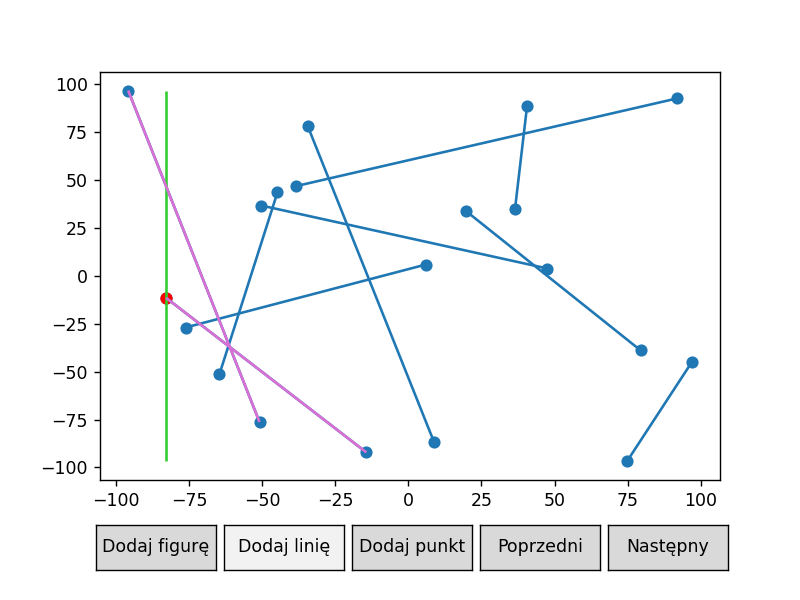

In [43]:
result_0, scenes_0 = check_intersection(data_lines_0)

if result_0:
    print("Przecięcie się prostych istnieje")
else:
    print("Przecięcie się prostych nie istnieje")
    
plot_0 = Plot(scenes=scenes_0)
plot_0.draw()

### zbiór nr 1

Przecięcie się prostych istnieje


<IPython.core.display.Javascript object>


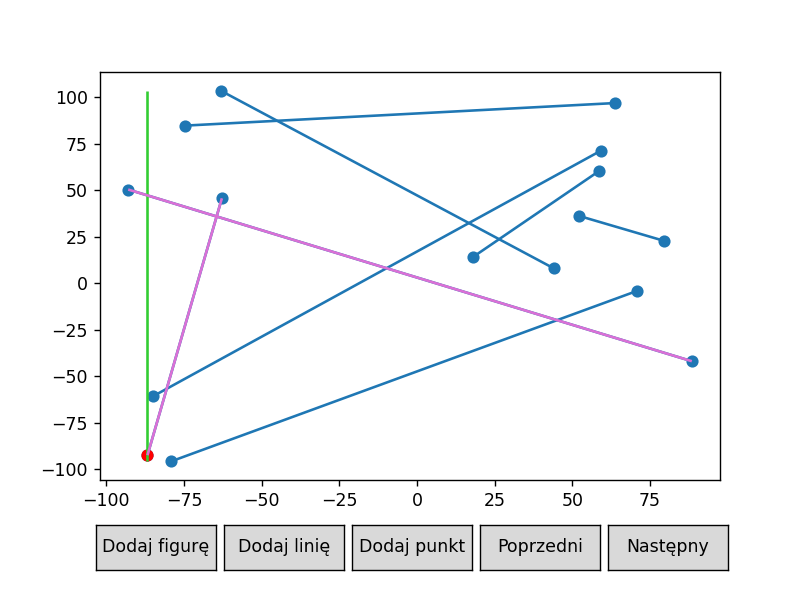

In [44]:
result_1, scenes_1 = check_intersection(data_lines_1)

if result_1:
    print("Przecięcie się prostych istnieje")
else:
    print("Przecięcie się prostych nie istnieje")
    
plot_1 = Plot(scenes=scenes_1)
plot_1.draw()

### zbiór nr 2

Przecięcie się prostych istnieje


<IPython.core.display.Javascript object>


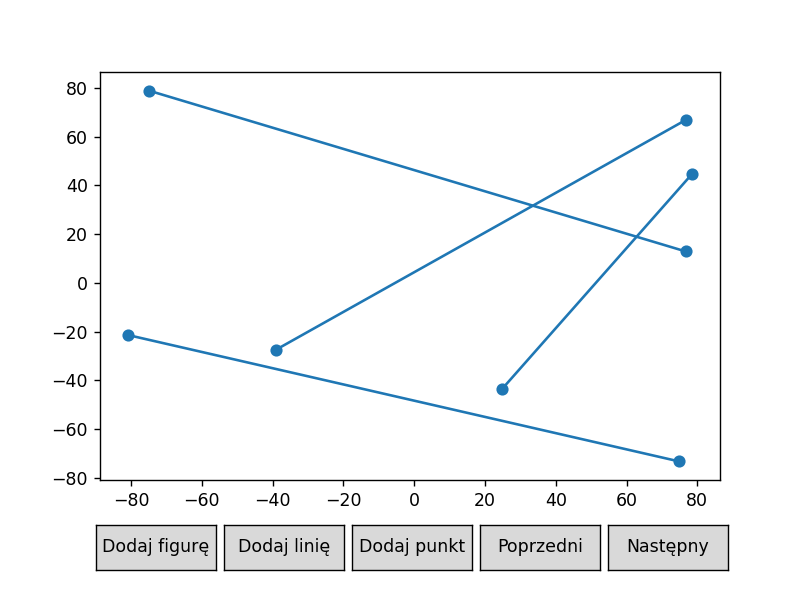

In [64]:
result_2, scenes_2 = check_intersection(data_lines_2)

if result_2:
    print("Przecięcie się prostych istnieje")
else:
    print("Przecięcie się prostych nie istnieje")
    
plot_2 = Plot(scenes=scenes_2)
plot_2.draw()

### zbiór nr 3

Przecięcie się prostych istnieje


<IPython.core.display.Javascript object>


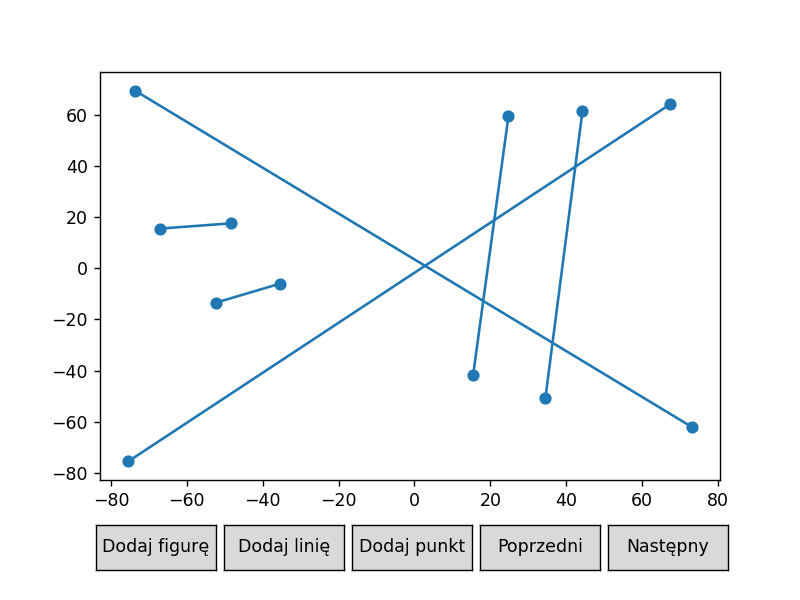

In [55]:
result_3, scenes_3 = check_intersection(data_lines_3)

if result_3:
    print("Przecięcie się prostych istnieje")
else:
    print("Przecięcie się prostych nie istnieje")
    
plot_3 = Plot(scenes=scenes_3)
plot_3.draw()

## Algorytm zamiatania 
## - sprawdzenie wszystkich przecięć odcinków

In [35]:
def intersection_point(line1, line2, precision=9):
    # wyznaczenie punktu przecięcia się podanych linii o zadanej precyzji
    
    inter_pt_x_val = (line2.b - line1.b)/(line1.a - line2.a)
    inter_pt_y_val = line1.a*inter_pt_x_val + line1.b
    
    return round(inter_pt_x_val, precision), round(inter_pt_y_val, precision)

In [36]:
def check_intersection_point(line1, line2, result, precision=9):
    # sprawdzenie czy w zbiorze wynikowym nie ma tego samego punktu przecięcia się
    # TRUE - może być dodany, gdy punkt nie powtarza się w zbiorze
    # FALSE - nie może być dodany, gdy punkt powtarza się w zbiorze
    
    inter_pt = intersection_point(line1, line2)
    
    for inter_pt_x_val, inter_pt_y_val, _ in result:
        if inter_pt[0] == round(inter_pt_x_val, precision) and inter_pt[1] == round(inter_pt_y_val, precision):
            return False
    return True

#### Wyznaczenie wszystkich punktów przecięć

In [37]:
def check_intersections(data_lines):
    # funkcja odpowiedzialna za wyznaczanie wszystkich punktów przecięć linii
    
    # sortowanie linii wg współrzędnych osi x dla początkowych punktów
    # zdefiniowanie kierunku zamiatania - wzdłuż osi X od najmniejszych do największych wartości
    data_lines.sort(key=lambda line: line[0][0])
    
    # struktura stanu miotły jako drzewo czerwono-czarne
    # zrównoważone drzewo poszukiwań
    State = FastRBTree()
    # struktura zdarzeń jako kolejka priorytetowa
    Queue = PriorityQueue()
    
    # wyznaczenie punktów wszystkich linii (do wizualizacji)
    data_points = [point for lines in data_lines for point in lines]
    
    result = []
    scenes = []
    intersection_points_plot = []
    points_now = []
    lines_now = []
    points_plot = data_points.copy()
    lines_plot = data_lines.copy()
    sweeper_plot = [] # miotła jako pionowa linia na rysunku
    
    # maksymalna i minimalna wartość wśród punktów danego zbioru linii
    # (potrzebne do wizualizacji miotły, aby obejmowała pionowo każdą z linii)
    y_max = max(data_points, key=lambda point: point[1])
    y_min = min(data_points, key=lambda point: point[1])
    
    # dodanie początkowej sceny do wizualizacji - linie i ich punkty
    scenes.append(Scene([PointsCollection(points_plot.copy())],
                        [LinesCollection(lines_plot.copy())])) 
    
    # zdefiniowanie punktów zdarzeń jako punkty początkowe, końcowe linii oraz powstałe z przecięcia linii
    # uporządkowane rosnąco względem osi x
    # dodatkowo przechowano krotkę z liniami przecinającymi się
    # przechowywane są kolejno: (wartość x punktu linii, (linia1, linia2), typ punktu)
    # linia2 początkowo zainicjowana jako None
    for line in data_lines:
        Queue.put((line[0][0], (line, None), "fst"))
        Queue.put((line[1][0], (line, None), "snd"))
        
    while not Queue.empty():
        # zdjęcie wierzchołka z kolejki wg priorytetu wartości pkt. względem osi x
        actual = Queue.get()
        x_val = actual[0] # aktualne położenie miotły względem osi x
        pt_type = actual[2] # typ punktu, początkowy (fst), końcowy (snd), z przecięcia (inter)
        sweeper_plot.append(((x_val, y_min[1]), (x_val, y_max[1])))
        
        # zdefiniowanie linii jako obiekt - instancja klasy Line
        # (potrzebne do wstawienia elementu do drzewa na podstawie porównywania elementów (linii) : __eq__ oraz __gt__)
        actual_line = Line(actual[1][0][0], actual[1][0][1])
        # ustawienie aktualnej pozycji miotły dla rozpatrywanej linii
        Line.x_val_now(actual[0])
        
        # jeżeli jest to wierzchołek początkowy linii, to wstawiony zostanie on do struktury stanu miotły
        if pt_type == "fst":
            points_now.append(actual_line.fst_pt)
            lines_now.append(actual_line.get_line())
            State.insert(actual_line, 1) # dodanie linii do struktury stanu miotły
            
            # sprawdzenie czy istnieje poprzednik rozpatrywanej linii w strukturze stanu miotły
            if State.min_key() != actual_line:
                pred, _ = State.prev_item(actual_line)
                lines_now.append(pred.get_line())
                
                # sprawdzenie czy aktualnie rozpatrywana linia przecina się z poprzednikiem
                if lines_intersection(pred.get_line(), actual_line.get_line()):
                    
                    # sprawdzenie czy punkt przecięcia aktualnej linii z poprzednikiem nie powtarza się w wyniku
                    if check_intersection_point(pred, actual_line, result):
                        inter_x, inter_y = intersection_point(pred, actual_line)
                        intersection_points_plot.append((inter_x, inter_y))
                        # wstawienie do struktury zdarzeń informacji o położeniu pkt. przecięcia,
                        # liniach przecinających się oraz informacji o typie punktu
                        Queue.put((inter_x, (pred.get_line(), actual_line.get_line()), "inter"))
                        # dodanie do wynikowej listy współrzędnych pkt. przecięcia oraz liniach przecinających się
                        result.append((inter_x, inter_y, (pred.get_line(), actual_line.get_line())))
             
            # sprawdzenie czy istnieje następnik rozpatrywanej linii w strukturze stanu miotły
            if State.max_key() != actual_line:
                succ, _ = State.succ_item(actual_line)
                lines_now.append(succ.get_line())
                
                # sprawdzenie czy aktualnie rozpatrywana linia przecina się z następnikiem
                if lines_intersection(actual_line.get_line(), succ.get_line()):
                    
                    # sprawdzenie czy punkt przecięcia aktualnej linii z następnikiem nie powtarza się w wyniku
                    if check_intersection_point(actual_line, succ, result):
                        inter_x, inter_y = intersection_point(actual_line, succ)
                        intersection_points_plot.append((inter_x, inter_y))
                        # wstawienie do struktury zdarzeń informacji o położeniu pkt. przecięcia,
                        # liniach przecinających się oraz informacji o typie punktu
                        Queue.put((inter_x, (actual_line.get_line(), succ.get_line()), "inter"))
                        # dodanie do wynikowej listy współrzędnych pkt. przecięcia oraz liniach przecinających się
                        result.append((inter_x, inter_y, (actual_line.get_line(), succ.get_line())))
                    
        
        # jeżeli jest to wierzchołek końcowy linii, to usunięty zostanie on ze struktury stanu miotły
        elif pt_type == "snd":
            points_now.append(actual_line.snd_pt)
            
            # sprawdzenie czy istnieje poprzednik i następnik rozpatrywanej linii
            if State.min_key() != actual_line and State.max_key() != actual_line:
                pred, _ = State.prev_item(actual_line)
                succ, _ = State.succ_item(actual_line)
                lines_now.extend([pred.get_line(), succ.get_line()])
                
                # sprawdzenie czy poprzednik i następnik usuwanej linii ze struktury stanu miotły przecinają się
                if lines_intersection(pred.get_line(), succ.get_line()):
                    
                    # sprawdzenie czy punkt przecięcia poprzednika z następnikiem nie powtarza się w wyniku
                    if check_intersection_point(pred, succ, result):
                        inter_x, inter_y = intersection_point(pred, succ)
                        intersection_points_plot.append((inter_x, inter_y))
                        Queue.put((inter_x, (pred.get_line(), succ.get_line()), "inter"))
                        result.append((inter_x, inter_y, (pred.get_line(), succ.get_line())))
                           
            State.remove(actual_line) # usunięcie linii ze struktury stanu miotły
        
        
        # jeżeli jest to punkt przecięcia się linii
        else:
            # utworzenie instancji linii przecinających się: pierwsza i druga
            fst_inter_line = Line(actual[1][0][0], actual[1][0][1])
            snd_inter_line = Line(actual[1][1][0], actual[1][1][1])
            points_now.append(intersection_point(fst_inter_line, snd_inter_line))
            lines_now.extend([fst_inter_line.get_line(), snd_inter_line.get_line()])
            
            # usunięcie linii przecinających się w odpowiedniej kolejności
            # (przy napotkaniu pkt. przecięcia się, zmniejszona zostaje wartość
            #  współrzędnej x, aby zachować kolejność usuwania ze struktury stanu)
            # - możliwe dzięki statycznej metodzie (Line.x_val_now), która obejmuje wszystkie instancje klasy Line
            step_val = 10**(-9)
            Line.x_val_now(actual[0] - step_val)
            State.remove(fst_inter_line)
            State.remove(snd_inter_line)
            
            # dodanie linii przecinających się w odpowiedniej kolejności
            # (zwiększona zostaje wartość współrzędnej x, aby zmienić kolejność dodawania do struktury stanu)
            Line.x_val_now(actual[0] + step_val)
            State.insert(fst_inter_line, 1)
            State.insert(snd_inter_line, 1)
            
            # sprawdzenie czy istnieje poprzednik pierwszej linii przecinającej się w strukturze stanu miotły 
            if State.min_key() != fst_inter_line:
                pred, _ = State.prev_item(fst_inter_line)
                
                # sprawdzenie czy druga linia przecinająca się nie jest poprzednikiem pierwszej w strukturze
                if pred != snd_inter_line:
                    lines_now.append(pred.get_line())
                    
                    # sprawdzenie czy pierwsza linia z poprzednikiem przecina się
                    if lines_intersection(pred.get_line(), fst_inter_line.get_line()):
                    
                        # sprawdzenie czy punkt przecięcia pierwszej linii z poprzednikiem nie powtarza się w wyniku
                        if check_intersection_point(pred, fst_inter_line, result):
                            inter_x, inter_y = intersection_point(pred, fst_inter_line)
                            intersection_points_plot.append((inter_x, inter_y))
                            Queue.put((inter_x, (pred.get_line(), fst_inter_line.get_line()), "inter"))
                            result.append((inter_x, inter_y, (pred.get_line(), fst_inter_line.get_line())))
             
            # sprawdzenie czy istnieje następnik pierwszej linii przecinającej się w strukturze stanu miotły
            if State.max_key() != fst_inter_line:
                succ, _ = State.succ_item(fst_inter_line)
                
                # sprawdzenie czy druga linia przecinająca się nie jest następnikiem pierwszej w strukturze
                if succ != snd_inter_line:
                    lines_now.append(succ.get_line())
                    
                    # sprawdzenie czy pierwsza linia z następnikiem przecina się
                    if lines_intersection(fst_inter_line.get_line(), succ.get_line()):
                    
                        # sprawdzenie czy punkt przecięcia pierwszej linii z następnikiem nie powtarza się w wyniku
                        if check_intersection_point(fst_inter_line, succ, result):
                            inter_x, inter_y = intersection_point(fst_inter_line, succ)
                            intersection_points_plot.append((inter_x, inter_y))
                            Queue.put((inter_x, (fst_inter_line.get_line(), succ.get_line()), "inter"))
                            result.append((inter_x, inter_y, (fst_inter_line.get_line(), succ.get_line())))
        
            # sprawdzenie czy istnieje poprzednik drugiej linii przecinającej się w strukturze stanu miotły
            if State.min_key() != snd_inter_line:
                pred, _ = State.prev_item(snd_inter_line)
                
                # sprawdzenie czy pierwsza linia przecinająca się nie jest poprzednikiem drugiej w strukturze
                if pred != fst_inter_line:
                    lines_now.append(pred.get_line())
                    
                    # sprawdzenie czy druga linia z poprzednikiem przecina się
                    if lines_intersection(pred.get_line(), snd_inter_line.get_line()):
        
                        # sprawdzenie czy punkt przecięcia drugiej linii z poprzednikiem nie powtarza się w wyniku
                        if check_intersection_point(pred, snd_inter_line, result):
                            inter_x, inter_y = intersection_point(pred, snd_inter_line)
                            intersection_points_plot.append((inter_x, inter_y))
                            Queue.put((inter_x, (pred.get_line(), snd_inter_line.get_line()), "inter"))
                            result.append((inter_x, inter_y, (pred.get_line(), snd_inter_line.get_line())))

            # sprawdzenie czy istnieje następnik drugiej linii przecinającej się w strukturze stanu miotły
            if State.max_key() != snd_inter_line:
                succ, _ = State.succ_item(snd_inter_line)
                
                # sprawdzenie czy pierwsza linia przecinająca się nie jest następnikiem drugiej w strukturze
                if succ != fst_inter_line:
                    lines_now.append(succ.get_line())
                    
                    # sprawdzenie czy druga linia z następnikiem przecina się
                    if lines_intersection(snd_inter_line.get_line(), succ.get_line()):
                    
                        # sprawdzenie czy punkt przecięcia drugiej linii z następnikiem nie powtarza się w wyniku
                        if check_intersection_point(snd_inter_line, succ, result):
                            inter_x, inter_y = intersection_point(snd_inter_line, succ)
                            intersection_points_plot.append((inter_x, inter_y))
                            Queue.put((inter_x, (snd_inter_line.get_line(), succ.get_line()), "inter"))
                            result.append((inter_x, inter_y, (snd_inter_line.get_line(), succ.get_line())))
        
        
        # dodanie kolejnej sceny do wizualizacji
        # punkty:
        # - kolor niebieski: wszystkie punkty zbioru
        # - kolor czerwony: aktualnie rozpatrywany punkt jako zdarzenie (wierzchołek początkowy lub końcowy linii)
        # - kolor pomarańczowy: punkt przecięcia prostych
        # linie:
        # - kolor niebieski: wszystkie linie zbioru
        # - kolor zielony: miotła
        # - kolor purpurowy: aktualne linie sąsiedztwa - poprzednik, następnik oraz rozpatrywana linia
        scenes.append(Scene([PointsCollection(points_plot),
                             PointsCollection(points_now.copy(), color="red"),
                             PointsCollection(intersection_points_plot.copy(), color="darkorange")],
                            [LinesCollection(lines_plot.copy()),
                             LinesCollection(sweeper_plot.copy(), color="limegreen"),
                             LinesCollection(lines_now.copy(), color="orchid")]))  
    
        
        # zwolnienie punktu zdarzenia, miotły oraz linii sąsiedztwa
        points_now.pop()
        sweeper_plot.pop()
        lines_now = []
             
    return result, scenes

In [38]:
def print_result(result):
    show_results = []
    names = ["Przecięcie nr", "Wsp. x pkt. przecięcia", "Wsp. y pkt. przecięcia", "Linia 1", "Linia 2"]
    num_of_intersections = len(result)
    
    for inter_num in range(num_of_intersections):
        x_val = format(result[inter_num][0], ".3f")
        y_val = format(result[inter_num][1], ".3f")
        line1 = list(map(lambda point: (round(point[0], 3), round(point[1], 3)), result[inter_num][2][0]))
        line2 = list(map(lambda point: (round(point[0], 3), round(point[1], 3)), result[inter_num][2][1]))
        
        show_results.append((inter_num + 1, x_val, y_val, line1, line2))
        
    results_df = pd.DataFrame(data=show_results, columns=names)
    pd.set_option("display.max_rows", num_of_intersections)
    
    return results_df.head(num_of_intersections).style.hide_index().set_properties(**{"text-align": "center"})

## Wyniki - sprawdzenia wszystkich przecięć odcinków

### zbiór nr 0

<IPython.core.display.Javascript object>


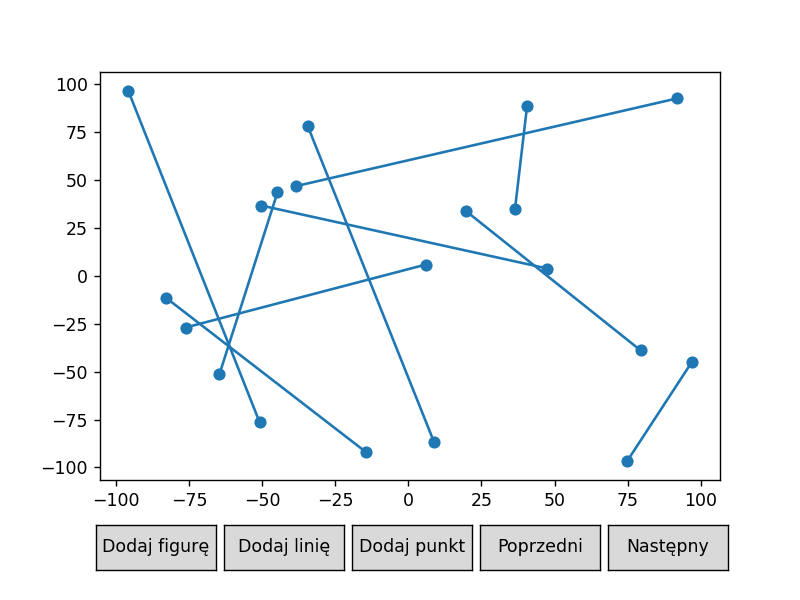

In [49]:
result_intersections_0, scenes_intersections_0 = check_intersections(data_lines_0)

plot_intersections_0 = Plot(scenes=scenes_intersections_0)
plot_intersections_0.draw()

In [47]:
result_df = print_result(result_intersections_0)
result_df

Przecięcie nr,Wsp. x pkt. przecięcia,Wsp. y pkt. przecięcia,Linia 1,Linia 2
1,-61.081,-37.188,"[(-82.865, -11.559), (-14.365, -92.148)]","[(-95.842, 96.601), (-50.917, -76.303)]"
2,-71.380,-25.071,"[(-76.233, -27.01), (5.924, 5.813)]","[(-82.865, -11.559), (-14.365, -92.148)]"
3,-64.901,-22.483,"[(-76.233, -27.01), (5.924, 5.813)]","[(-95.842, 96.601), (-50.917, -76.303)]"
4,-61.546,-36.640,"[(-64.625, -51.354), (-44.784, 43.456)]","[(-82.865, -11.559), (-14.365, -92.148)]"
5,-61.402,-35.951,"[(-64.625, -51.354), (-44.784, 43.456)]","[(-95.842, 96.601), (-50.917, -76.303)]"
6,-58.007,-19.729,"[(-64.625, -51.354), (-44.784, 43.456)]","[(-76.233, -27.01), (5.924, 5.813)]"
7,-46.484,35.335,"[(-64.625, -51.354), (-44.784, 43.456)]","[(-50.308, 36.619), (47.551, 3.766)]"
8,-27.245,50.677,"[(-38.47, 46.737), (92.035, 92.549)]","[(-34.488, 78.304), (8.76, -86.656)]"
9,-20.978,26.772,"[(-50.308, 36.619), (47.551, 3.766)]","[(-34.488, 78.304), (8.76, -86.656)]"
10,-13.453,-1.929,"[(-76.233, -27.01), (5.924, 5.813)]","[(-34.488, 78.304), (8.76, -86.656)]"


### zbiór nr 1

<IPython.core.display.Javascript object>


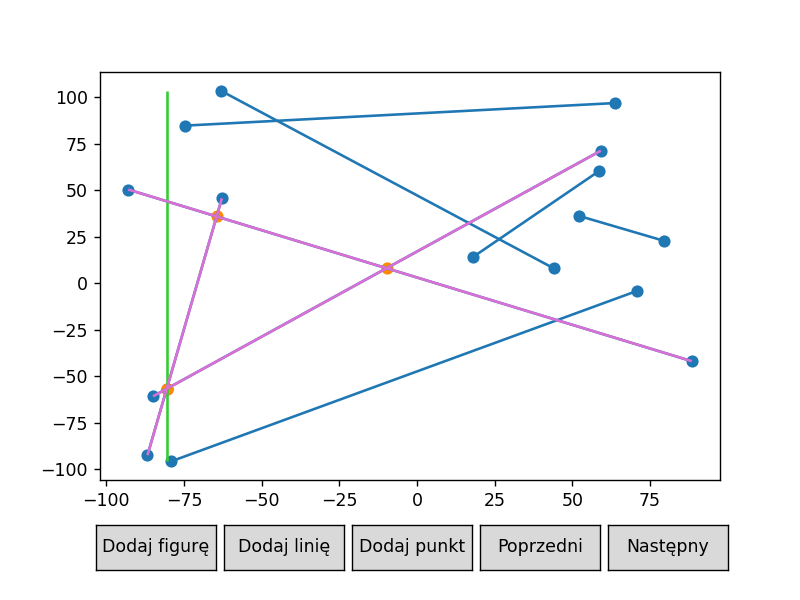

In [46]:
result_intersections_1, scenes_intersections_1 = check_intersections(data_lines_1)

plot_intersections_1 = Plot(scenes=scenes_intersections_1)
plot_intersections_1.draw()

In [42]:
result_df = print_result(result_intersections_1)
result_df

Przecięcie nr,Wsp. x pkt. przecięcia,Wsp. y pkt. przecięcia,Linia 1,Linia 2
1,-64.473,35.960,"[(-86.73, -92.442), (-62.779, 45.732)]","[(-92.94, 50.45), (88.471, -41.89)]"
2,-80.537,-56.713,"[(-86.73, -92.442), (-62.779, 45.732)]","[(-84.956, -60.763), (59.197, 71.345)]"
3,-9.788,8.125,"[(-84.956, -60.763), (59.197, 71.345)]","[(-92.94, 50.45), (88.471, -41.89)]"
4,-44.984,87.435,"[(-74.755, 84.825), (63.633, 96.958)]","[(-63.222, 103.698), (44.116, 7.987)]"
5,16.719,32.416,"[(-84.956, -60.763), (59.197, 71.345)]","[(-63.222, 103.698), (44.116, 7.987)]"
6,45.102,-19.815,"[(-79.19, -95.812), (70.729, -4.145)]","[(-92.94, 50.45), (88.471, -41.89)]"
7,26.448,23.742,"[(17.947, 14.053), (58.754, 60.561)]","[(-63.222, 103.698), (44.116, 7.987)]"


### zbiór nr 2

<IPython.core.display.Javascript object>


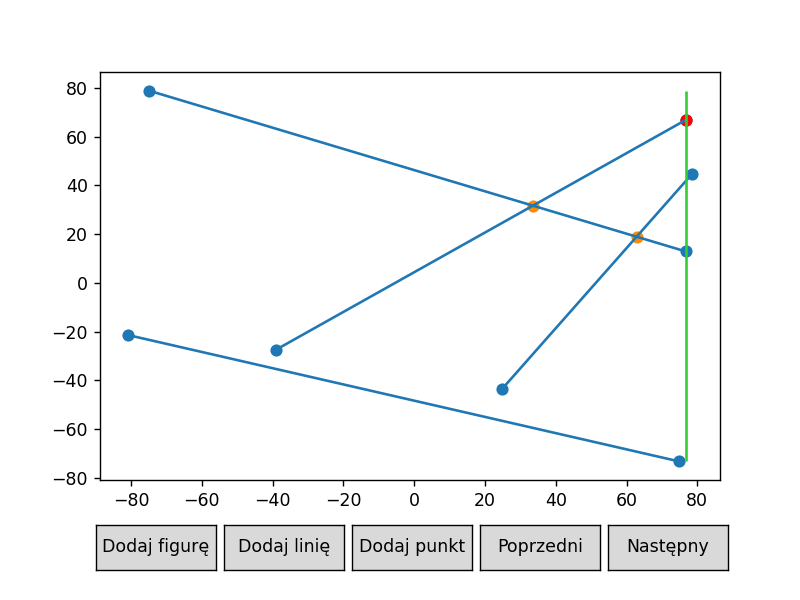

In [65]:
result_intersections_2, scenes_intersections_2 = check_intersections(data_lines_2)

plot_intersections_2 = Plot(scenes=scenes_intersections_2)
plot_intersections_2.draw()

In [66]:
result_df = print_result(result_intersections_2)
result_df

Przecięcie nr,Wsp. x pkt. przecięcia,Wsp. y pkt. przecięcia,Linia 1,Linia 2
1,33.555,31.683,"[(-39.093, -27.534), (76.673, 66.829)]","[(-75.021, 78.961), (76.673, 12.907)]"
2,62.850,18.926,"[(24.778, -43.71), (78.447, 44.586)]","[(-75.021, 78.961), (76.673, 12.907)]"


### zbiór nr 3

<IPython.core.display.Javascript object>


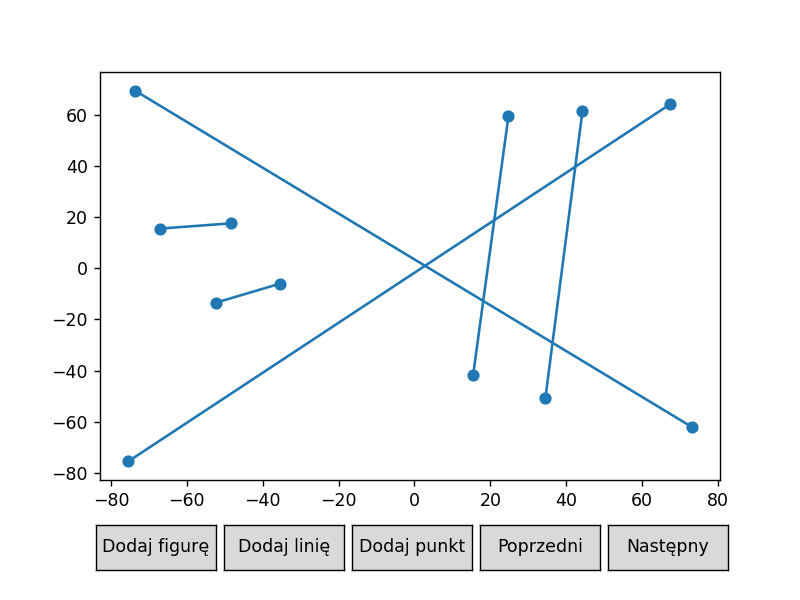

In [58]:
result_intersections_3, scenes_intersections_3 = check_intersections(data_lines_3)

plot_intersections_3 = Plot(scenes=scenes_intersections_3)
plot_intersections_3.draw()

In [59]:
result_df = print_result(result_intersections_3)
result_df

Przecięcie nr,Wsp. x pkt. przecięcia,Wsp. y pkt. przecięcia,Linia 1,Linia 2
1,2.790,0.914,"[(-75.464, -75.532), (67.358, 63.99)]","[(-73.69, 69.382), (73.124, -62.052)]"
2,18.136,-12.824,"[(15.463, -41.831), (24.778, 59.272)]","[(-73.69, 69.382), (73.124, -62.052)]"
3,21.044,18.746,"[(15.463, -41.831), (24.778, 59.272)]","[(-75.464, -75.532), (67.358, 63.99)]"
4,36.404,-29.178,"[(34.536, -50.594), (44.294, 61.294)]","[(-73.69, 69.382), (73.124, -62.052)]"
5,42.403,39.611,"[(34.536, -50.594), (44.294, 61.294)]","[(-75.464, -75.532), (67.358, 63.99)]"
